In [19]:
# notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# external imports
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
N_sim = 50

In [21]:
e_sigmas = [0., 0.001, 0.003, 0.010]
nodes = {}
nodes_ws = {}
len_ws = {}
for e in e_sigmas:
    nodes[e] = list(np.load('data/nodes_cs_sd_%.3f.npy'%e, allow_pickle=True))
    if e == 0.:
        nodes_ws[e] = np.load('data/nodes_ws_sd_%.3f.npy'%e, allow_pickle=True)[:,1:]
        len_ws[e] = np.load('data//nodes_len_ws_sd_%.3f.npy'%e, allow_pickle=True)[:,:-1]
    else:
        nodes_ws[e] = [n[1:] for n in np.load('data/nodes_ws_sd_%.3f.npy'%e, allow_pickle=True)]
        len_ws[e] = [n[:-1] for n in np.load('data//nodes_len_ws_sd_%.3f.npy'%e, allow_pickle=True)]

In [22]:
# remove infeasible trajecotories
for e in e_sigmas[1:]:
    nodes[e] = [n for n in nodes[e] if len(n) == N_sim]
    nodes_ws[e] = [n for n in nodes_ws[e] if len(n) == N_sim-1]
    len_ws[e] = [n for n in len_ws[e] if len(n) == N_sim-1]

In [23]:
def get_statistics(data, len_data):
    mins = []
    p80 = []
    p90 = []
    maxs = []
    for t in range(len_data):
        n_t = [float(n[t]) for n in data]
        mins.append(min(n_t))
#         means.append(sum(n_t)/len(n_t))
#         means.append(np.median(n_t))
        p80.append(np.percentile(n_t, 80))
        p90.append(np.percentile(n_t, 90))
        maxs.append(max(n_t))
    return mins, p80, p90, maxs

In [24]:
def plot_statistics(ax, data, t0=0, **kwargs):
    mins, p80, p90, maxs = get_statistics(data, N_sim-t0)
    ax.plot(range(t0, N_sim), mins, **kwargs)
    ax.plot(range(t0, N_sim), maxs, **kwargs)
    ax.plot(range(t0, N_sim), p80, linestyle='--', **kwargs)
    ax.plot(range(t0, N_sim), p90, linestyle=':', **kwargs)
    ax.fill_between(range(t0, N_sim), mins, maxs, alpha=.1, **kwargs)

In [25]:
from decimal import Decimal

def fexp(number):
    (sign, digits, exponent) = Decimal(number).as_tuple()
    return len(digits) + exponent - 1

def fman(number):
    return Decimal(number).scaleb(-fexp(number)).normalize()

In [26]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 12})

<IPython.core.display.Javascript object>


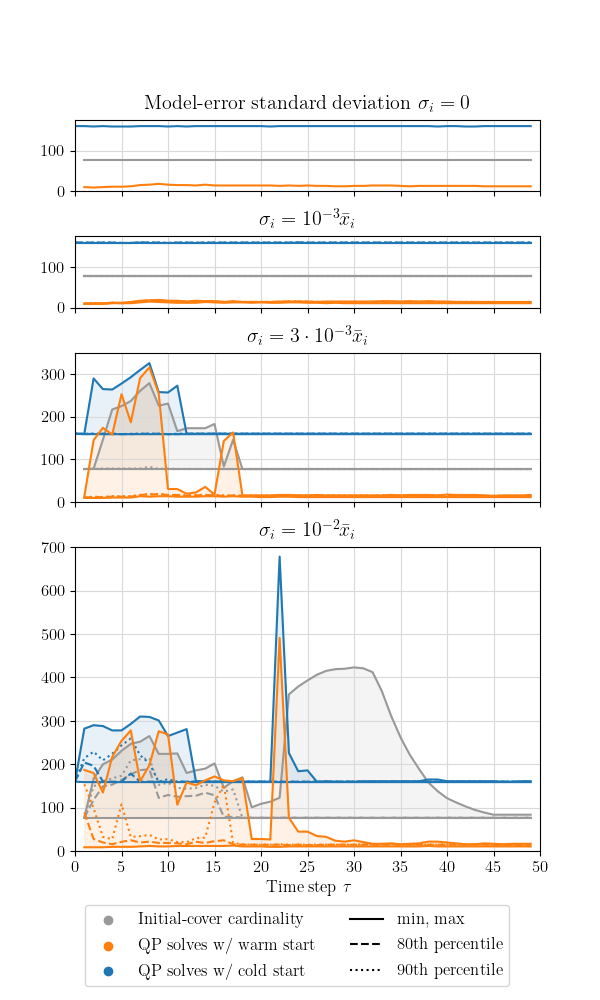

In [36]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(6,10))
gridspec.GridSpec(20,1)

# sizes of the subplots
heights = [175, 175, 350, 700]
rowspans = [2, 2, 4, 8]
xticks = range(0, N_sim+1, 5)

# nominal case
plt.subplot2grid((20, 1), (0,0), rowspan=rowspans[0], colspan=1)
plt.title(r'Model-error standard deviation $\sigma_i = 0$')
plt.plot(range(1,len(len_ws[0.][0])+1), len_ws[0.][0], color=np.ones(3)*.6)#'#2ca02c')
plt.plot(range(len(nodes[0.][0])), nodes[0.][0], color='#1f77b4')
plt.plot(range(1,len(nodes_ws[0.][0])+1), nodes_ws[0.][0], color='#ff7f0e')
plt.grid(True, color=np.ones(3)*.85)
plt.xlim(0, N_sim)
plt.ylim(0, heights[0])
plt.xticks(xticks, ['']*len(xticks))

# with disturbances
for i, e in enumerate(e_sigmas[1:]):
    i += 1
    plt.subplot2grid(
        (20, 1),
        (sum(rowspans[:i]) + i,0),
        rowspan=rowspans[i],
        colspan=1
    )
    plot_statistics(plt, len_ws[e], t0=1, color=np.ones(3)*.6)#'#2ca02c')
    plot_statistics(plt, nodes[e], color='#1f77b4')
    plot_statistics(plt, nodes_ws[e], t0=1, color='#ff7f0e')
    plt.grid(True, color=np.ones(3)*.85)
    plt.xlim(0, N_sim)
    plt.ylim(0, heights[i])
    plt.xticks(xticks, ['']*len(xticks))
    coef = float(fman(e_sigmas[i]))
    exp = fexp(e_sigmas[i])
    if coef == 1.:
        plt.title(r'$\sigma_i = 10^{%.0f} \bar x_i$'%exp)
    else:
        plt.title(r'$\sigma_i = %.0f \cdot 10^{%.0f} \bar x_i$'%(coef,exp))
    
# x axis
plt.xlabel(r'Time step $\tau$')
plt.xticks(xticks, xticks)
    
# legend
plt.scatter(-10., -10., color='#ff7f0e', label='QP solves w/ warm start')
plt.scatter(-10., -10., color='#1f77b4', label='QP solves w/ cold start')
plt.scatter(-10., -10., color=np.ones(3)*.6, label=r'Initial-cover cardinality')#'#2ca02c')
plt.plot(-10., -10., color='k', label='min, max')
plt.plot(-10., -10., color='k', linestyle='--', label='80th percentile')
plt.plot(-10., -10., color='k', linestyle=':', label='90th percentile')
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,4,5,0,1,2] # 3 columns
lgd = plt.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    loc='upper center',
    bbox_to_anchor=(0.477, -0.15),
    ncol=2
)

fig.savefig('nodes.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')